# COVID-19 Epidemiology Models

First, some preliminary imports. You may need to pip install `holoviews` and `GitPython`. For `holoviews`, some extras might be needed (see https://holoviews.org/install.html).

In [1]:
import pandas as pd
import numpy as np
import scipy.integrate

import bokeh.io
import bokeh.application
import bokeh.application.handlers
import bokeh.models


import holoviews as hv

bokeh.io.output_notebook()
hv.extension('bokeh')

ModuleNotFoundError: No module named 'holoviews'

In [2]:
import matplotlib.pyplot as plt

Let's load the data from the relevant folder. If this data doesn't exist for you, you'll need to run the `processing/raw_data_processing/daily_refresh.sh` script (which may require `pip install us`).

In [3]:
import git

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
datadir = f"{homedir}/data/international/italy/"

Load the Italian data by region (20 regions, but one of them is divided into 2, so we have 21 territories).

In [4]:
df = pd.read_csv(datadir + 'covid/dpc-covid19-ita-regioni.csv')

In [5]:
df['date_processed'] = pd.to_datetime(df['Date'].values)
df['date_processed'] = (df['date_processed'] - df['date_processed'].min()) / np.timedelta64(1, 'D')

Just checking to make sure the data is here...

In [6]:
df.head()

,Date,County,Regional Code,Region,Latitude,Longitude,HospitalizedWithSymptoms,IntensiveCare,TotalHospitalized,HomeIsolation,TotalCurrentlyPositive,NewCurrentlyPositive,DischargedHealed,Deaths,TotalCases,Tested,Note_IT,Note_ENG,date_processed
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5,NaN,NaN,0.0
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0.0
2,2020-02-24T18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1,NaN,NaN,0.0
3,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,1,NaN,NaN,0.0
4,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10,NaN,NaN,0.0


Add on the total population data, used to estimate the number of susceptible people later.

In [7]:
populations = pd.read_csv(datadir + 'demographics/region-populations.csv')
def get_population(region):
    if region == 'Emilia-Romagna':
        region = 'Emilia Romagna'
    return populations[populations['Region'] == region]['Population'].values[0]

In [8]:
df['Population'] = df.apply(lambda row: get_population(row.Region), axis=1)

Great! Let's also make a helper function to select data from a region, starting when the pandemic hit to be able to fit models.

In [9]:
# return data ever since first min_cases cases
def select_region(df, region, min_deaths=50):
    d = df.loc[df['Region'] == region]
    start = np.where(d['Deaths'].values > min_deaths)[0][0]
    d = d[start:]
    return d

## erf model

Let's start with a simple model used in this major paper by IHME: https://www.medrxiv.org/content/10.1101/2020.03.27.20043752v1. Just fit an erf function, nothing else.

In [11]:
from scipy.special import erf
from scipy.optimize import curve_fit

def erf_curve(t, logp, a, b):
    p = 10**logp
    deaths = p/2*(1+erf(a*(t-b)))
    return deaths

def erf_model(params, data, future=0):
    # initial conditions
    p = 10**params[0]
    a = params[1]
    b = params[2]
    
    t = data['date_processed'].values
    if future > 0:
        extrapolation = np.arange(future)
        t = np.concatenate((t, extrapolation + t[-1] + 1))
    deaths = p/2*(1+erf(a*(t-b)))
    
    return t, deaths

def erf_fit(params, data):
    Draw = data['Deaths'].values
    Draw[np.where(Draw < 1)] = 1
    Ddata = Draw
    t, Draw = erf_model(params, data)
    Draw[np.where(Draw < 1)] = 1
    D = Draw
    
    error = mse(D, Ddata)
    
    return error

Now let's try to have something to run the fit and plot the results, including a prediction. To estimate errors, we'll use `curve_fit` and the covariance matrix it returns. Sampling parameters from a Gaussian distribution around the fit, we then bootstrap errors corresponding to 25th and 75th percentile predictions.

In [38]:
from bokeh.models import Span

def plot_erf_with_errors_sample(df, region, extrapolate=1, boundary=None):
    '''
    df: main italy data frame
    region: string (region name)
    extrapolate: run model on this * length of data (ex. extrapolate=1 does no prediction, extrapolate=2 predicts a time interval equal in length to the data length)
    boundary: train model on data until the day demarcated by boundary; if boundary is None, train on all available data
    '''
    data = select_region(df, region)
    keys = ['Deaths', 'TotalCurrentlyPositive']
    all_out = []
    proper = []
    for k in keys:
        erf_params0 = [np.log10(np.max(data[k])), 0.1, 30]
        y = data[k].values[:boundary]
        popt, pcov = curve_fit(erf_curve, data['date_processed'].values[:boundary], y, p0=erf_params0)
        errors = np.sqrt(np.diag(pcov))

        all_s = []
        samples = 100
        for i in range(samples):
            sample = np.random.normal(loc=popt, scale=errors)
            t, y = erf_model(sample, data, future=len(data)*(extrapolate-1))
            all_s.append(y)
        
        all_s = np.array(all_s)
        all_out.append(all_s)
        
        t, y = erf_model(popt, data, future=len(data)*(extrapolate-1))
        proper.append(y)
    
    t = np.arange(0, len(data))
    tp = np.arange(0, len(data)*extrapolate)

    p = bokeh.plotting.figure(plot_width=600,
                              plot_height=400,
                             title = region + ' erf Model',
                             x_axis_label = 't (days)',
                             y_axis_label = '# people')

    p1 = 25
    p2 = 75
    p.varea(x=tp, y1=np.percentile(all_out[1], p1, axis=0), y2=np.percentile(all_out[1], p2, axis=0), color='purple', fill_alpha=0.2)
    p.varea(x=tp, y1=np.percentile(all_out[0], p1, axis=0), y2=np.percentile(all_out[0], p2, axis=0), color='black', fill_alpha=0.2)
    
#     s1 = np.percentile(all_s, 40, axis=0)
#     s2 = np.percentile(all_s, 60, axis=0)
#     p.varea(x=tp, y1=s1[:, 2], y2=s2[:, 2], color='red', fill_alpha=0.2)
#     p.varea(x=tp, y1=s1[:, 3], y2=s2[:, 3], color='purple', fill_alpha=0.2)
#     p.varea(x=tp, y1=s1[:, 5], y2=s2[:, 5], color='black', fill_alpha=0.2)
    
    p.line(tp, proper[0], color = 'black', line_width = 1, legend_label = 'Deceased')
    p.line(tp, proper[1] , color = 'purple', line_width = 1, legend_label = 'Symptomatic infected')

    # death
    p.circle(t, data['Deaths'], color ='black')

    # quarantined
    p.circle(t, data['TotalCurrentlyPositive'], color ='purple')
    
    if boundary is not None and boundary < len(data):
        vline = Span(location=boundary, dimension='height', line_color='black', line_width=3)
        p.renderers.extend([vline])

    p.legend.location = 'top_left'
    bokeh.io.show(p)

And how well does this model do at prediction? We train it on days 0-16 (left of the vertical line), and we try to predict days afterwards.

In [17]:
plot_erf_with_errors_sample(df, 'Lombardia', 2, 16)

Hm. Let's check how it performs more systematically. Let's try adjusting how long we train and predict for.

In [39]:
start = 12
step = 4
ind = 0
results = []
one_more = False
while start + ind*step <= 28:
    boundary = start + ind*step
    plot_erf_with_errors_sample(df, 'Lombardia', 2, boundary)
    ind += 1

The model seems to think that the pandemic will flatten out in the next couple days. Given the earlier plots, I doubt that is right. We can check it on another region and see what happens! What regions can we choose from? We need a region with enough data.

In [29]:
regions = sorted(np.unique(df['Region'].values))
print(regions)
print([np.amax(df.loc[df['Region'] == r]['TotalCases'].values) for r in regions])

['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto']
[1293, 202, 614, 1759, 13119, 1480, 2706, 3076, 41007, 3558, 127, 1214, 1594, 8206, 1549, 638, 1460, 4122, 1023, 584, 8358]


The predictions look a little better for Emilia Romagna, but it appears that the error bars for anything earlier than 16-day prediction are enormous. By the time you reach 20 days, however, we only have 22 days of data, so it seems a little trivial to predict.

In [40]:
start = 16
step = 4
ind = 0
results = []
one_more = False
while start + ind*step <= 24:
    boundary = start + ind*step
    plot_erf_with_errors_sample(df, 'Emilia Romagna', 2, boundary)
    ind += 1

Time to move on to a more standard epidemiological model.

## SEIR-QD model

Ok, will this model isn't too standard. It's selected as one of the best-performing models from "Rational evaluation of various epidemic models based on the COVID-19 data of China" (https://www.medrxiv.org/content/10.1101/2020.03.12.20034595v1.full.pdf), where it turned out to be one of the better models in terms of early-stage data collection. It takes into effect quarantine and self-protection, but not from data; it just makes assumptions about how people behave. The differential equations can be found on page 8 of the supplement: https://www.medrxiv.org/content/medrxiv/suppl/2020/03/16/2020.03.12.20034595.DC1/2020.03.12.20034595-1.pdf. Thanks @Liana Merk for doing the initial work on this model!

Parameters:
* $\beta$ = infection rate, from earlier plotting, $10^{(-8)} - 10^{(-6)}$ seem reasonable.
* $\delta$ = recovery rate, which we think is on the order of 10-40 days.
* $\gamma$ = transition of exposed individuals to infected, which we aren't sure of, especially with the unknown number of asymptomatics.
* $\alpha$ = protection rate of susceptible individuals, which we also don't know, and is most likely dynamic over the course of the outbreak.
* $\lambda$ = transition rate of infected to quarantined with infection, same as above.
* $\kappa$ = death rate, which we think is around 0.01-0.06. We will leave a range between 0.01 and 0.1.

In [47]:
def seirqd(dat, t, params, N):
    beta = params[0] / N
    delta = params[1]
    gamma = params[2]
    alpha = params[3]
    lambda_ = params[4]
    kappa = params[5]
    
    s = dat[0]
    e = dat[1]
    i = dat[2]
    q = dat[3]
    r = dat[4]
    d = dat[5]
    sa = dat[6]
    
    dsdt = - beta * s * i - alpha * s
    dedt = beta * s * i - gamma * e
    didt = gamma * e - lambda_ * i
    dqdt = lambda_ * i - delta * q - kappa * q
    drdt = delta * q
    dddt = kappa * q
    dsadt = alpha * s
    
    # susceptible, exposed, infected, quarantined, recovered, died, unsusceptible
    return [dsdt, dedt, didt, dqdt, drdt, dddt, dsadt]

In [48]:
from sklearn.metrics import mean_squared_error

def mse_qd(A, B):
    Ap = np.nan_to_num(A)
    Bp = np.nan_to_num(B)
    Ap[A == -np.inf] = 0
    Bp[B == -np.inf] = 0
    Ap[A == np.inf] = 0
    Bp[B == np.inf] = 0
    return mean_squared_error(Ap, Bp)

def model_qd(params, data, tmax=-1):
    # initial conditions
    N = data['Population'].values[0] # total population
    initial_conditions = N * np.array(params[-5:]) # the parameters are a fraction of the population so multiply by the population
    
    # initial conditions
    e0 = initial_conditions[0]
    i0 = initial_conditions[1]
    q0 = initial_conditions[2]
    r0 = initial_conditions[3]
    sa0 = initial_conditions[4]
    
    d0 = data['Deaths'].values[0]
    s0 = N - np.sum(initial_conditions) - d0

    yz_0 = np.array([s0, e0, i0, q0, r0, d0, sa0])
    
    # Package parameters into a tuple
    args = (params, N)
    
    n = len(data)
    if tmax > 0:
        n = tmax
    
    # Integrate ODEs
    s = scipy.integrate.odeint(seirqd, yz_0, np.arange(0, n), args=args)

    return s

def fit_leastsq_qd(params, data):
    Ddata = (data['Deaths'].values)
    Idata = (data['TotalCurrentlyPositive'].values)
    s = model_qd(params, data)

    S = s[:,0]
    E = s[:,1]
    I = s[:,2]
    Q = s[:,3]
    R = s[:,4]
    D = s[:,5]
    SA = s[:,6]
    
    error = np.concatenate((D-Ddata, I - Idata))
    return error

Let's check if this is reasonable with a manual fit to Lombardia. Anyway, we need to provide the optimization method an initial guess of the parameters, so this gives us a good chance to make a reasonable guess and speed up the optimization. Some good guesses are provided by the SEIR model here: https://gabgoh.github.io/COVID/index.html.

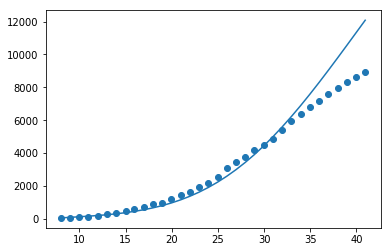

In [49]:
%matplotlib notebook
%matplotlib inline

plt.figure()
d = select_region(df, 'Lombardia')
# parameters: beta, delta, gamma, alpha, lambda, kappa
params = [2.0, 0.3, 0.2, 0.05, 0.2, 0.03]
# parameters: beta, sigma, ra, shift
# params = [1.1, 0.8, 0.2, 0.3]
# conditions: E, I, Q, R, SA
initial_conditions = [0.5e-3, 0.5e-3, 0.3e-3, 0.1e-4, 0.5]
s = model_qd(params + initial_conditions, d, False)
plt.scatter(d['date_processed'], d['Deaths'])
plt.plot(d['date_processed'], s[:, 5])
plt.show()

Looks good! How about actually fitting it now? We need a plotting function!

In [57]:
import itertools

def plot_qd(res, p0_params, p0_initial_conditions, df, region, extrapolate=1, boundary=None, plot_infectious=False):
    data = select_region(df, region)
    
    s = model_qd(res.x, data, len(data)*extrapolate)
    S = s[:,0]
    E = s[:,1]
    I = s[:,2]
    Q = s[:,3]
    R = s[:,4]
    D = s[:,5]
    SA = s[:,6]

    t = np.arange(0, len(data))
    tp = np.arange(0, len(data)*extrapolate)

    p = bokeh.plotting.figure(plot_width=600,
                              plot_height=400,
                             title = region + ' SEIR-QD Model',
                             x_axis_label = 't (days)',
                             y_axis_label = '# people')

    if plot_infectious:
        p.line(tp, I, color = 'red', line_width = 1, legend_label = 'All infected')
    p.line(tp, D, color = 'black', line_width = 1, legend_label = 'Deceased')

    # death
    p.circle(t, data['Deaths'], color ='black')

    # quarantined
    p.circle(t, data['TotalCurrentlyPositive'], color ='purple', legend_label='Tested infected')
    
    if boundary is not None:
        vline = Span(location=boundary, dimension='height', line_color='black', line_width=3)
        p.renderers.extend([vline])

    p.legend.location = 'top_left'
    bokeh.io.show(p)

We'll need to estimate errors from the optimization procedure. I transferred some of the relevant code from `curve_fit` to work for this kind of model:

In [51]:
from scipy.linalg import svd
# return params, 1 standard deviation errors
def get_errors(res, p0):
    p0 = np.array(p0)
    ysize = len(res.fun)
    cost = 2 * res.cost  # res.cost is half sum of squares!
    popt = res.x
    # Do Moore-Penrose inverse discarding zero singular values.
    _, s, VT = svd(res.jac, full_matrices=False)
    threshold = np.finfo(float).eps * max(res.jac.shape) * s[0]
    s = s[s > threshold]
    VT = VT[:s.size]
    pcov = np.dot(VT.T / s**2, VT)

    warn_cov = False
    absolute_sigma = False
    if pcov is None:
        # indeterminate covariance
        pcov = zeros((len(popt), len(popt)), dtype=float)
        pcov.fill(inf)
        warn_cov = True
    elif not absolute_sigma:
        if ysize > p0.size:
            s_sq = cost / (ysize - p0.size)
            pcov = pcov * s_sq
        else:
            pcov.fill(inf)
            warn_cov = True

    if warn_cov:
        print('cannot estimate variance')
        return None
    
    perr = np.sqrt(np.diag(pcov))
    return perr

To do the optimization, we should define reasonable ranges for the parameters as well.

In [52]:
param_ranges = [(0.5, 3.0), (0.0, 0.5), (0.0, 0.5), (0.01, 0.5), (0.0, 0.5), (0.005, 0.1)]
initial_ranges = [(1.0e-7, 0.01), (1.0e-7, 0.01), (1.0e-7, 0.01), (1.0e-7, 0.01), (1.0e-7, 0.9)]
guesses = params + initial_conditions
ranges = param_ranges + initial_ranges

In [53]:
from scipy.optimize import least_squares
res = least_squares(fit_leastsq_qd, guesses, args=(select_region(df, 'Lombardia'),), bounds=np.transpose(np.array(ranges)))

In [58]:
plot_qd(res, params, initial_conditions, df, 'Lombardia', extrapolate=2, plot_infectious=True)

In [55]:
from scipy.optimize import least_squares
res = least_squares(fit_leastsq_qd, guesses, args=(select_region(df, 'Lombardia')[:20],), bounds=np.transpose(np.array(ranges)))

In [59]:
plot_qd(res, params, initial_conditions, df, 'Lombardia', extrapolate=2, boundary=20, plot_infectious=True)

This is quite misleading! We don't actually know how many people are infected, so this model isn't quite what we're looking for. Instead, we only know the people who were tested as infected; they usually have symptoms. I won't bother with the error analysis for this model, but we can see how it holds up to prediction.

In [119]:
start = 10
step = 4
ind = 0
results = []
one_more = False
while start + ind*step <= 28:
    boundary = start + ind*step
    res = least_squares(fit_leastsq_qd, guesses, args=(select_region(df, 'Lombardia')[:boundary],), bounds=np.transpose(np.array(ranges)))
    plot_qd(res, params, initial_conditions, df, 'Lombardia', extrapolate=2, boundary=boundary, plot_infectious=True)
    ind += 1

Despite being conceptually wrong, this produces much more satisfactory predictions of fatality rates than the erf model. The infectious predictions should be taken with a (very large) grain of salt anyway, since we know it isn't really predicting the infected population.

## Fancy stuff: $\mathbf{SEI_A I_S R}$ with empirical quarantine

The motivation for this model is to add two crucial ingredients: quarantine data and asymptomatic cases. For quarantine analysis, we find an effective population size based on what fraction of the population is moving according to https://citymapper.com/cmi/milan. (Since Milan is the capital of Lombardy, we perform the analysis for that region.) To make the quarantine more realistic, we model a "leaky" quarantine, where the susceptible population is given by the mobility from above plus some offset. To treat asymptomatic cases, we introduce states $I_A$ (asymptomatic) and $I_S$ (symptomatic) according to the following sketch and differential equations:

![SEIIR + quarantine](images/overview.png)

Since this is prototyping the model, we manually enter the chart above (raw data is at the link above) and implement it. We also have a testing function $T(t)$ (called `tau(t)` in the code) that allows us to try out different testing strategies for asymptomatic populations. Sorry about the confusing variable names below: parameters are renamed as $\sigma\to$ `alpha`, $s\to$ `sigma`, and $d\to$ `delta`. Not shown in the equations above but included in the diagram is a fixed offset (`offset`) for the leaky quarantine model.

In [139]:
# TODO fix data imputation
def q(t, N, shift):
    moving = np.array([57, 54, 52, 51, 49, 47, 46, 45, 44, 43, 39, 37, 34, 23, 19, 13, 10, 7, 6, 5, 5, 7, 6, 5, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 2])/100
    q = N*(1-moving) - shift*N
    if np.round(t) >= len(q):
        return q[-1]
    return q[int(np.round(t))]
    
def tau(t):
    return 0

def seiirq(dat, t, params, N, max_t, offset):
    if t >= max_t:
        return [0]*8
    beta = params[0]
    alpha = params[1] # rate from e to ia
    sigma = params[2] # rate of asymptomatic people becoming symptotic
    ra = params[3] # rate of asymptomatic recovery
    rs = params[4] # rate of symptomatic recovery
    delta = params[5] # death rate
    shift = params[6] # shift quarantine rate vertically from CityMapper data
    
    s = dat[0]
    e = dat[1]
    i_a = dat[2]
    i_s = dat[3]

    Qind = (q(t + offset, N, shift) - tau(t + offset)*i_a)/(s + e + i_a - tau(t + offset)*i_a)
    Qia = Qind + (1-Qind)*tau(t + offset)
    
    dsdt = - beta * s * i_a * (1 - Qind) * (1 - Qia) / N
    dedt = beta * s * i_a* (1 - Qind) * (1 - Qia) / N  - alpha * e
    diadt = alpha * e - (sigma + ra) * i_a
    disdt = sigma * i_a - (delta + rs) * i_s
    dddt = delta * i_s
    drdt = ra * i_a + rs * i_s
    
    
    # susceptible, exposed, infected, quarantined, recovered, died, unsusceptible
    out = [dsdt, dedt, diadt, disdt, drdt, dddt]
    return out

In [137]:
from sklearn.metrics import mean_squared_error

def mse(A, B):
    Ap = np.nan_to_num(A)
    Bp = np.nan_to_num(B)
    Ap[A == -np.inf] = 0
    Bp[B == -np.inf] = 0
    Ap[A == np.inf] = 0
    Bp[B == np.inf] = 0
    return mean_squared_error(Ap, Bp)

def model_z(params, data, tmax=-1):
    # initial conditions
    N = data['Population'].values[0] # total population
    initial_conditions = N * np.array(params[-4:]) # the parameters are a fraction of the population so multiply by the population
    
    e0 = initial_conditions[0]
    ia0 = initial_conditions[1]
    is0 = initial_conditions[2]
    r0 = initial_conditions[3]
    
    d0 = data['Deaths'].values[0]
    s0 = N - np.sum(initial_conditions) - d0

    offset = data['date_processed'].min()
    yz_0 = np.array([s0, e0, ia0, is0, r0, d0])
    
    n = len(data)
    if tmax > 0:
        n = tmax
    
    # Package parameters into a tuple
    args = (params, N, n, offset)
    
    # Integrate ODEs
    try:
        s = scipy.integrate.odeint(seiirq, yz_0, np.arange(0, n), args=args)
    except RuntimeError:
#         print('RuntimeError', params)
        return np.zeros((n, len(yz_0)))

    return s

def fit_leastsq_z(params, data):
    Ddata = (data['Deaths'].values)
    Idata = (data['TotalCurrentlyPositive'].values)
    s = model_z(params, data)

    S = s[:,0]
    E = s[:,1]
    I_A = s[:,2]
    I_S = s[:,3]
    R = s[:,4]
    D = s[:,5]
    
    error = np.concatenate((D-Ddata, I_S - Idata))
    return error

Again, we find some good initial parameters.

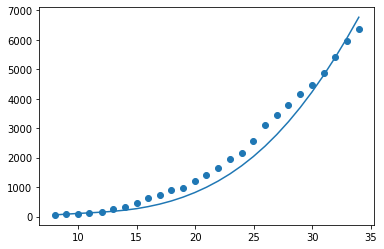

In [129]:
%matplotlib notebook
%matplotlib inline

plt.figure()
d = select_region(df, 'Lombardia')
# parameters: beta, alpha, sigma, ra, rs, delta, shift
params = [1.8, 0.35, 0.1, 0.15, 0.34, 0.015, 0.5]
# conditions: E, IA, IS, R
initial_conditions = [4e-6, 0.0009, 0.0005, 0.0002]
s = model_z(params + initial_conditions, d)
plt.scatter(d['date_processed'], d['Deaths'])
plt.plot(d['date_processed'], s[:, 5])
plt.show()

In [130]:
import itertools

def plot_with_errors_sample_z(res, p0_params, p0_initial_conditions, df, region, extrapolate=1, boundary=None, plot_infectious=False):
    data = select_region(df, region)
    errors = get_errors(res, list(p0_params) + list(p0_initial_conditions))
    errors[len(p0_params):] = 0
    
    all_s = []
    samples = 100
    for i in range(samples):
        sample = np.random.normal(loc=res.x, scale=errors)
        s = model_z(sample, data, len(data)*extrapolate)
        all_s.append(s)
        
    all_s = np.array(all_s)
    
    s = model_z(res.x, data, len(data)*extrapolate)
    S = s[:,0]
    E = s[:,1]
    I_A = s[:,2]
    I_S = s[:,3]
    R = s[:,4]
    D = s[:,5]

    t = np.arange(0, len(data))
    tp = np.arange(0, len(data)*extrapolate)

    p = bokeh.plotting.figure(plot_width=600,
                              plot_height=400,
                             title = region + ' SEIIRD+Q Model',
                             x_axis_label = 't (days)',
                             y_axis_label = '# people')

    s1 = np.percentile(all_s, 25, axis=0)
    s2 = np.percentile(all_s, 75, axis=0)
    if plot_infectious:
        p.varea(x=tp, y1=s1[:, 2], y2=s2[:, 2], color='red', fill_alpha=0.2)
    p.varea(x=tp, y1=s1[:, 3], y2=s2[:, 3], color='purple', fill_alpha=0.2)
    p.varea(x=tp, y1=s1[:, 5], y2=s2[:, 5], color='black', fill_alpha=0.2)
    
    if plot_infectious:
        p.line(tp, I_A, color = 'red', line_width = 1, legend_label = 'Asymptomatic infected')
    p.line(tp, D, color = 'black', line_width = 1, legend_label = 'Deceased')
    p.line(tp, I_S , color = 'purple', line_width = 1, legend_label = 'Symptomatic infected')

    # death
    p.circle(t, data['Deaths'], color ='black')

    # quarantined
    p.circle(t, data['TotalCurrentlyPositive'], color ='purple')
    
    if boundary is not None:
        vline = Span(location=boundary, dimension='height', line_color='black', line_width=3)
        p.renderers.extend([vline])

    p.legend.location = 'top_left'
    bokeh.io.show(p)

Let's define the initial ranges of the constants for the ODE.

In [131]:
# beta, alpha, sigma, ra, rs, delta, shift
param_ranges = [(1.0, 2.0), (0.1, 0.5), (0.1, 0.5), (0.05, 0.5), (0.32, 0.36), (0.005, 0.05), (0.1, 0.6)]
initial_ranges = [(1.0e-7, 0.001), (1.0e-7, 0.001), (1.0e-7, 0.001), (1.0e-7, 0.001)]

guesses = params + initial_conditions
ranges = param_ranges + initial_ranges

In [140]:
start = 16
step = 4
ind = 0
results = []
one_more = False
while start + ind*step <= 28:
    boundary = start + ind*step
    res = least_squares(fit_leastsq_z, guesses, args=(select_region(df, 'Lombardia')[:boundary],), bounds=np.transpose(np.array(ranges)))
    plot_with_errors_sample_z(res, params, initial_conditions, df, 'Lombardia', extrapolate=2, boundary=boundary, plot_infectious=True)
    ind += 1

RuntimeError [1.68282502e+00 2.00357099e-01 1.59581752e-01 1.86009793e-01
 3.34566310e-01 2.00882425e-02 4.67308902e-01 2.90714641e-04
 9.88775881e-04 4.03666747e-04 6.65199373e-04]


RuntimeError [1.73685623e+00 3.65963954e-01 1.71204266e-01 2.31225049e-01
 1.29873679e-01 2.57537624e-02 4.71566164e-01 1.04815320e-04
 9.39951856e-04 4.59565262e-04 2.38216207e-04]


RuntimeError [1.76491644e+00 2.90673836e-01 2.14568959e-01 1.69261910e-01
 3.27999705e-01 1.94599387e-02 4.86971352e-01 2.55717390e-04
 9.95660783e-04 4.78475744e-04 2.89177460e-04]


Just like SEIR-QD, the predictions of cases aren't so great, although the predictions of fatalaties (which matters more and has less data bias) is reasonably accurate. The model also produces prediction that around 2/3 of the cases are asymptomatic (or at least not tested). This corresponds roughly to some recent studies, such as the 50-75% number reported after testing an entire town of 3,300 in Italy (https://www.repubblica.it/salute/medicina-e-ricerca/2020/03/16/news/coronavirus_studio_il_50-75_dei_casi_a_vo_sono_asintomatici_e_molto_contagiosi-251474302/?ref=RHPPTP-BH-I251454518-C12-P3-S2.4-T1) and similar results in Iceland (https://www.government.is/news/article/2020/03/15/Large-scale-testing-of-general-population-in-Iceland-underway/).